In [20]:
!pip install -U qiskit qiskit-aer pylatexenc matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.

QFT Circuit for 2 qubits:


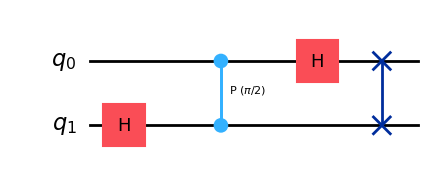

QFT Circuit for 3 qubits:


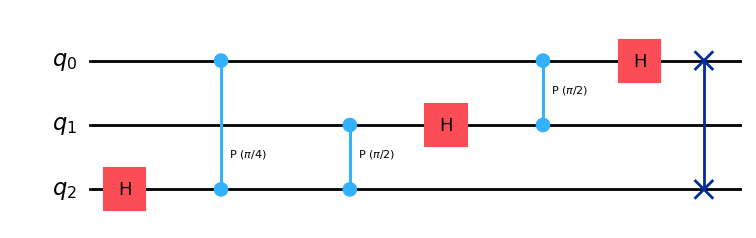

QFT Circuit for 4 qubits:


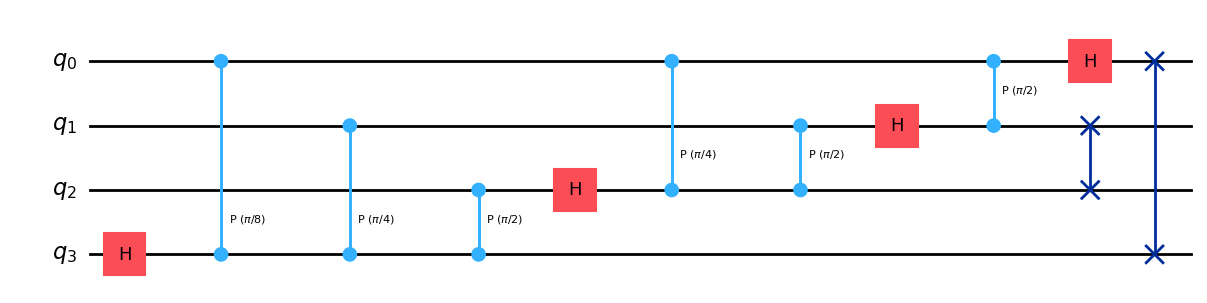

Inverse QFT Circuit (3 qubits):


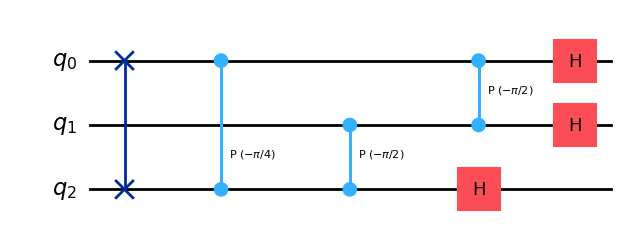

/tmp/ipython-input-1375481265.py:73: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(num_qubits=n_count, inverse=True).to_gate()


Phase Estimation Circuit with QFT:


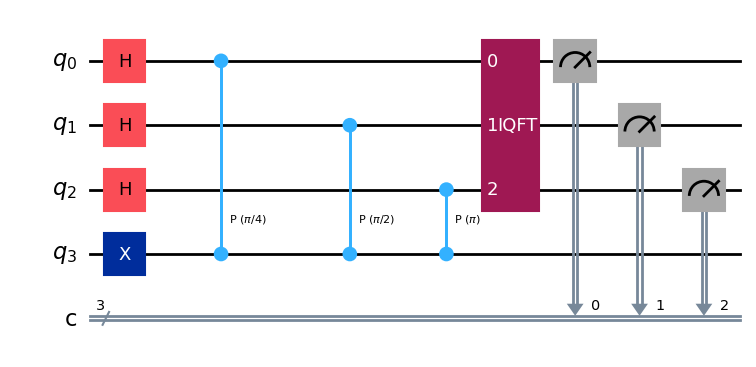

Measurement Results:
{'001': 1024}
Bloch Sphere for 3-qubit QFT:


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import QFT
import numpy as np
import matplotlib.pyplot as plt

def qft_rotations(qc, n):
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qubit in range(n):
        qc.cp(np.pi / 2 ** (n - qubit), qubit, n)
    qft_rotations(qc, n)
    return qc

def swap_registers(qc, n):
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

def qft_circuit(n):
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    swap_registers(qc, n)
    qc.name = "QFT"
    return qc

def inverse_qft_rotations(qc, n):
    if n == 0:
        return qc
    n -= 1
    for qubit in range(n):
        qc.cp(-np.pi / 2 ** (n - qubit), qubit, n)
    qc.h(n)
    inverse_qft_rotations(qc, n)
    return qc

def inverse_qft_circuit(n):
    qc = QuantumCircuit(n)
    swap_registers(qc, n)
    inverse_qft_rotations(qc, n)
    qc.name = "IQFT"
    return qc

def run_qft_statevector(n):
    qc = qft_circuit(n)
    simulator = AerSimulator(method='statevector')
    qc.save_statevector()
    result = simulator.run(transpile(qc, simulator)).result()
    statevector = result.data(0)["statevector"]
    print(f"Bloch Sphere for {n}-qubit QFT:")
    plot_bloch_multivector(statevector)
    plt.show()

for n in [2, 3, 4]:
    print(f"QFT Circuit for {n} qubits:")
    qc = qft_circuit(n)
    display(qc.draw('mpl'))

print("Inverse QFT Circuit (3 qubits):")
iqft = inverse_qft_circuit(3)
display(iqft.draw('mpl'))

def phase_estimation_example():
    n_count = 3
    qc = QuantumCircuit(n_count + 1, n_count)
    qc.h(range(n_count))
    qc.x(n_count)
    for qubit in range(n_count):
        qc.cp(np.pi / 4 * (2 ** qubit), qubit, n_count)
    iqft = QFT(num_qubits=n_count, inverse=True).to_gate()
    qc.append(iqft, range(n_count))
    qc.measure(range(n_count), range(n_count))
    return qc

phase_qc = phase_estimation_example()
print("Phase Estimation Circuit with QFT:")
display(phase_qc.draw('mpl'))

simulator = AerSimulator()
compiled = transpile(phase_qc, simulator)
result = simulator.run(compiled, shots=1024).result()
counts = result.get_counts()
print("Measurement Results:")
print(counts)
plot_histogram(counts)
plt.show()

run_qft_statevector(3)
